In [1]:
import time
import numpy as np
import numpy.linalg as nl
import scipy.linalg as sl
import scipy.special as sps
import scipy.integrate as si
import scipy.optimize as spo
import matplotlib.pyplot as plt
from jax.config import config
import jax
import jax.numpy as jnp
import jax.numpy.linalg as jnl
config.update("jax_enable_x64", True)

<h1>TDSE Forward Problem</h1>

In [2]:
# size of spatial domain
a = 10.0

# set number of real space grid points for plotting
nx = 1025
# spatial grid for the purposes of plotting
xvec = np.linspace(-a, a, nx)

# the basis functions used in our Fourier representation
# will be from n = -numF to n = numF
numF = 32
# matrix for converting Fourier basis coefficients to real space values
Fnvec = np.arange(-numF, numF + 1) # Fnvec=-nfb,...,0,...,nfb
Fcnvrtmat = np.exp(1j * np.pi * np.outer(Fnvec, xvec) / a) / np.sqrt(2 * a)

---
**Potential Function**

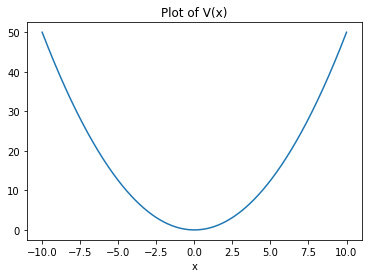

In [3]:
# define potential for generating training data

def v(x):
    # dimensionless quantum harmonic oscillator potential
    return 0.5 * x**2
    # rescaled symmetric double well potential
    # return 0.0025*(x**2 - 25)**2
    # scaled asymmetric double well potential
    # return 0.0003*((x-3)**4 + 10*(x-5)**3)
    # soft coulomb potential
    # return -1 / np.sqrt(x**2 + 0.25)

# compute true potential for plotting
vxvec = v(xvec)

# plot true potential
plt.plot(xvec, vxvec)
plt.title('Plot of V(x)')
plt.xlabel('x')
plt.show()

---
**Eigendecomposition of a Fourier Represented Potential**

In [4]:
# transform potential function to Fourier representation
# using quadrature method
# (in tdse-adj-cheb-fft-vs-quad-kbc.ipynb we show that the
# using a quadrature method produces much more accurate results)
Fvtoep = []
for thisn in range(2 * numF + 1):
    def intgrnd(x):
        return v(x) * np.exp(-1j * np.pi * thisn * x / a) / (2 * a)
    def rintgrnd(x):
        return intgrnd(x).real
    def iintgrnd(x):
        return intgrnd(x).imag
    Fvtoep.append(si.quad(rintgrnd, -a, a)[0] + 1j * si.quad(iintgrnd, -a, a)[0])
Fvtoep = np.array(Fvtoep)
Fvmat = sl.toeplitz(r=Fvtoep, c=Fvtoep.conj())

print(Fvmat.shape)

# kinetic matrix = kinetic operator in the Fourier basis
# this is a constant
kmat = np.diag(np.arange(-numF, numF + 1) ** 2 * np.pi ** 2 / (2 * a ** 2))

# Hamiltonian matrix = Hamiltonian operator in the Fourier basis
Fhmat = kmat + Fvmat

# check if the Hamiltonian matrix is Hermitian
print('hmat Hermitian check (should be close to zero):', nl.norm(Fhmat - Fhmat.T.conj()), sep='\n')

# eigen-decomposition of the Hamiltonian matrix
Fspc, Fstts = nl.eigh(Fhmat)

# check if the eigendecomposition diagonalizes the
# Hamiltonian matrix
# if this is close to zero then
# hmat = states @ np.diag(spec) @ np.conj(states).T
print('Check if hmat is diagonalized (should be close to zero):', nl.norm(Fhmat @ Fstts - Fstts @ np.diag(Fspc)), sep='\n')

# check if the eigenstates are unitary
print('Unitary stts check (should be close to zero):', nl.norm(Fstts @ Fstts.T.conj() - np.eye(2 * numF + 1)), sep='\n')

(65, 65)
hmat Hermitian check (should be close to zero):
0.0
Check if hmat is diagonalized (should be close to zero):
3.392077258042753e-13
Unitary stts check (should be close to zero):
1.2469110651416776e-14


[0.5 1.5 2.5 3.5 4.5 5.5]


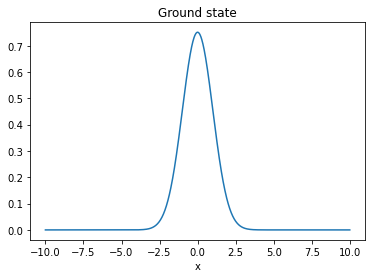

Quick check of normalization (should be close to 1):
0.9999999999999993
Check of normalization (should be close to 1):
0.9999999999999993


In [5]:
# find indices that sort eigenvalues
ordering = np.argsort(Fspc)

# print the first few eigenvalues
print(Fspc[ordering[:6]])

# pick out and plot ground state
groundstate = ordering[0]
wavefn = Fstts[:,groundstate] @ Fcnvrtmat
plt.plot(xvec, np.real(wavefn))
plt.title('Ground state')
plt.xlabel('x')
plt.show()

# quick and dirty check of normalization
print('Quick check of normalization (should be close to 1):', np.sum(np.abs(wavefn)**2 * (xvec[1]-xvec[0])), sep='\n')

# this should be a more accurate check of the ground state
# wave functions' normalization
print('Check of normalization (should be close to 1):', si.trapezoid(np.abs(wavefn)**2, xvec), sep='\n')

---
**Initial Wave Function and its Fourier Representation**

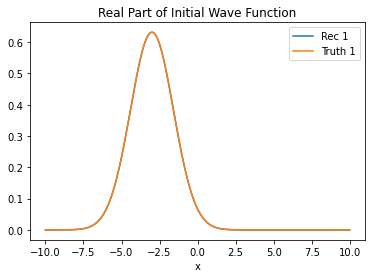

L2 Error psi0: 4.072507283500472e-06
a-infinity Error psi0: 1.8301527573114097e-06


In [6]:
# define initial state(s) and transform to Fourier basis

def psi0(x):
    # return 1.0 + np.tanh((1 - x**2)/0.5)  # rounded box function
    # return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - np.abs(x)), 0])  # triangular pulse
    # return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - x**2), 0])  # parabolic pulse
    # return (np.cosh(x))**(-2)  # hyperbolic secant squared
    # return np.exp(-np.abs(x))  # Laplace
    # HSB's "super simple initial condition"
    # return np.exp(-x**2) * (2.0 / np.pi)**0.25  # Gaussian with a^2 norm = 1
    #
    return np.exp(-(x + 3)**2 / 4) * (2.0 / np.pi)**0.25
    # return np.exp(-(x + 7)**2 / 0.2) * (2.0 / np.pi)**0.25

# WHEN USING HSB'S GAUSSIAN WITH a^2 NORM = 1
# norm_psi0_fn = psi0
# WHEN NOT USING HSB'S GAUSSIAN WITH a^2 NORM = 1
# compute psi0 normalization term
psi0_prob_intgrnd = lambda x: np.abs(psi0(x)) ** 2
psi0_norm = np.sqrt(si.quad(psi0_prob_intgrnd, -a, a)[0])
# define normalized psi function to be used by
# a scipy.integrate methods
def norm_psi0_fn(x):
    return psi0(x) / psi0_norm

# compute the Fourier basis representation of the
# normalized psi0 function using quadrature method
normpsi0quad = np.zeros(numF + 1, dtype=np.complex128)
for thisn in range (numF + 1):
    def intgrnd(x):
        return norm_psi0_fn(x) * np.exp(-1j * np.pi * thisn * x / a) / np.sqrt(2 * a)
    def rintgrnd(x):
        return intgrnd(x).real
    def iintgrnd(x):
        return intgrnd(x).imag
    normpsi0quad[thisn] = si.quad(rintgrnd, -a, a)[0] + 1j * si.quad(iintgrnd, -a, a)[0]

ainit = np.concatenate([np.conjugate(np.flipud(normpsi0quad[1:])), normpsi0quad])

normpsi0vecrec = ainit @ Fcnvrtmat
normpsi0vec = norm_psi0_fn(xvec)

# plot the real part of the normalized psi0
plt.plot(xvec, normpsi0vecrec.real, label="Rec 1")
plt.plot(xvec, normpsi0vec.real, label="Truth 1")
plt.title('Real Part of Initial Wave Function')
plt.xlabel('x')
plt.legend()
plt.show()

print('L2 Error psi0:', nl.norm(normpsi0vecrec - normpsi0vec))
print('a-infinity Error psi0:', np.max(np.abs(normpsi0vecrec - normpsi0vec)))

---
<h3>Foward Propagation</h3>

**of ainit using the Potential in the Fourier Representation**

In [42]:
# solve the forward problem in the Fourier
# representation and store the trajectory
# in Famat

# set the size of a time step
dt = 1e-2

# set the number of time steps to take starting from
# the initial state (a single trajectory should be
# nts + 1 states, this includes the initial state)
ntsteps = 600  # 400  # 200  # 100

# compute the propagator matrix reusing the
# spectrum and states from the eigendecomposition
# of Hamiltonian matrix computed above
Fpropa = Fstts @ np.diag(np.exp(-1j * Fspc * dt)) @ Fstts.conj().T

# propagate the system starting from the initial "a" state
Famat = np.zeros((ntsteps + 1, 2 * numF + 1), dtype=np.complex128)
Famat[0] = ainit.copy()
for i in range(ntsteps):
    Famat[i + 1] = Fpropa @ Famat[i]

# compute the wave function in space from each "a" vector
# do it all at once using matrix multiplication!
Fpsimat = Famat @ Fcnvrtmat

print('Done propagating.')

Done propagating.


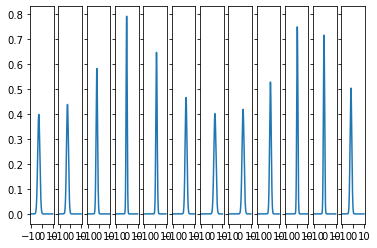

In [43]:
numsnapshots = 12

fig, axs = plt.subplots(nrows=1, ncols=numsnapshots, sharex='all', sharey='all')

plottstep = ntsteps // numsnapshots


for j in range(numsnapshots):
    axs[j].plot(xvec, np.abs((Famat @ Fcnvrtmat)[plottstep * j])**2)

plt.show()

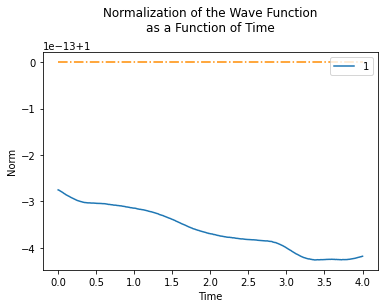

Average Norm of Trajectory Fpsimatnormvec (should be close to 1):
0.9999999999996388


In [36]:
# check if the wave function of each time step
# is normalized to 1
# this should produce a graph with a line that is almost
# completely horizontal at 1
Fpsimatnormvec = si.trapezoid(np.abs(Fpsimat) ** 2, xvec, axis=1)
plt.plot(np.arange(ntsteps + 1) * dt, Fpsimatnormvec, label='1')
plt.hlines(1 , 0, ntsteps * dt, linestyles='-.', colors='darkorange', label='_')
plt.title('Normalization of the Wave Function\nas a Function of Time\n')
plt.xlabel('Time')
plt.ylabel('Norm')
plt.legend()
plt.show()

# norm difference of wave function normalization check,
# this should be close to 1
print('Average Norm of Trajectory Fpsimatnormvec (should be close to 1):', Fpsimatnormvec.sum() / (ntsteps + 1), sep='\n')

---
<h1>Inverse Problem - Adjoint Method</h1>

[ 2.50000000e+01  4.73695157e-15  2.50000000e+01  3.55271368e-15
 -9.47390314e-15  2.13162821e-14 -5.92118946e-15  1.42108547e-14
 -1.06581410e-14  1.65793305e-14 -3.43428989e-14  2.13162821e-14]


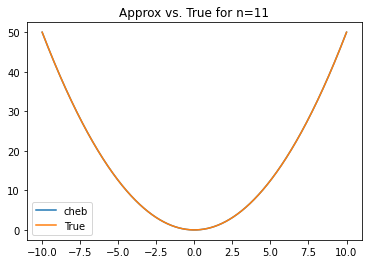

L2 Error (should be close to zero):
9.054280613274888e-13
a-infinity Error (should be close to zero):
1.5631940186722204e-13


In [10]:
# set up Chebyshev representation

# set the number of Chebyshev coefficients
nc = 11

def theta(k):
    return (k - 0.5) * np.pi / (nc + 1)

def g(k):
    return v(a * np.cos(theta(k)))

kvec = np.arange(1, nc + 2)
cnvec = np.arange(0, nc + 1)

cweights = np.ones(nc + 1)
cweights[0] = 0.5

# compute Chebyshev coefficients
cvec = 2 / (nc + 1) * np.sum(g(kvec) * np.cos(cnvec[..., np.newaxis] * theta(kvec)), axis=1)
cvec = cweights * cvec
print(cvec)

ctoxmat = sps.eval_chebyt(np.expand_dims(cnvec, 0), np.expand_dims(xvec / a, 1))
vrec = ctoxmat @ cvec

# plot reconstruction vs truth
plt.plot(xvec, vrec, label='cheb')
plt.plot(xvec, vxvec, label='True')
plt.title(f'Approx vs. True for n={nc}')
plt.legend()
plt.show()

# vec L2 error
print('L2 Error (should be close to zero):', nl.norm(v(xvec) - vrec), sep='\n')
# a-infinity error
print('a-infinity Error (should be close to zero):', np.max(np.abs(v(xvec) - vrec)), sep='\n')

In [11]:
# creates matrix that can be used to transform
# the Chebyshev coefficients to the Fourier representation
CtoFmat = []
for thiscn in range(nc + 1):
    temptoeprow = []
    for thisn in range(2 * numF + 1):
        def intgrnd(x):
            return sps.eval_chebyt(thiscn, x / a) * np.exp(-1j * np.pi * thisn * x / a) / (2 * a)
        def rintgrnd(x):
            return intgrnd(x).real
        def iintgrnd(x):
            return intgrnd(x).imag
        temptoeprow.append(si.quad(rintgrnd, -a, a)[0] + 1j * si.quad(iintgrnd, -a, a)[0])
    CtoFmat.append(sl.toeplitz(r=temptoeprow, c=np.conj(temptoeprow)))

CtoFmat = np.array(CtoFmat).T
print('Shape CtoFmat:', CtoFmat.shape)

Shape CtoFmat: (65, 65, 12)


In [12]:
# convert python list to JAX object
jaxFamat = jnp.stack(Famat)
print(jaxFamat.shape)

# convert the NumPy CtoFmat matrix to a JAX object
jaxCtoFmat = jnp.array(CtoFmat)
print(jaxCtoFmat.shape)

2022-03-31 20:06:01.397362: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-03-31 20:06:01.397409: W external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


(201, 65)
(65, 65, 12)


In [13]:
def cobjfn(cffs):
    vhatmat = jaxCtoFmat @ cffs
    # print('L2 Error vmat (should be close to 0):', jnl.norm(vmat - cvmat), sep='\n')

    # construct the Hamiltonian matrix
    hhatmat = kmat + vhatmat
    # print('L2 Error hmat (should be close to 0):', jnl.norm(hmat - chmat), sep='\n')

    # eigendecomposition of the Hamiltonian matrix
    spchat, sttshat = jnl.eigh(hhatmat)
    # print('L2 Error spc (should be close to 0):', jnl.norm(spc - cspc), sep='\n')
    # print('L2 Error stts (should be close to 0):', jnl.norm(stts - cstts), sep='\n')

    # compute the propagator matrix using the
    # result of the eigendecomposition
    propahatmat = sttshat @ jnp.diag(jnp.exp(-1j * spchat * dt)) @ sttshat.conj().T
    # print('L2 Error propamat (should be close to 0):', jnl.norm(propamat - cpropa), sep='\n')

    # propagate the system starting from the initial "a" state
    ahatmat = [ainit.copy()]
    for i in range(ntsteps):
        ahatmat.append(propahatmat @ ahatmat[i])
    # make python list a jax object
    ahatmat = jnp.stack(ahatmat)

    # compute the sum of objective functions in one line
    residue = ahatmat - jaxFamat
    objective = jnp.sum(0.5 * jnp.real(jnp.sum(jnp.conj(residue) * residue, axis=1)))

    return objective

In [14]:
# check if the objective function gives zero when the
# chebyshev coefficients of the true potential are fed in
# this should produce a result which is very close to zero
print('Objective for True Chebyshev Coefficients (should be close to 0):', cobjfn(cvec), sep='\n')

Objective for True Chebyshev Coefficients (should be close to 0):
3.4875522371822186e-24


In [15]:
jitcobjfn = jax.jit(cobjfn)

In [16]:
jitcobjfn(cvec)

DeviceArray(3.48755224e-24, dtype=float64)

In [17]:
jaxgradcobjfn = jax.jit(jax.grad(cobjfn))

In [18]:
# check if the JAX grad of the objective function works
# this should give all zeros (or close to that)
print('Shape jaxgradcobjfn(cvec):', jaxgradcobjfn(cvec).shape)
print('jaxgradcobjfn(cvec) (should be close to 0):', jaxgradcobjfn(cvec), sep='\n')

Shape jaxgradcobjfn(cvec): (12,)
jaxgradcobjfn(cvec) (should be close to 0):
[-2.57426533e-12  1.24697617e-12  1.80244603e-12 -3.22312797e-12
  1.78714839e-13  3.85783991e-12 -2.48741352e-12 -2.91178557e-12
  4.06290802e-12  8.92807262e-13 -4.19652243e-12  1.16553883e-12]


---
**Adjoint Method for Calculating Grads of the Objective Function**

In [19]:
# this code is used to make a toeplitz matrix from the
# Fourier representation
# flattoepvec = jnp.concatenate([jnp.flipud(cvrow.conj()), cvrow[1:]])

numtoepelms = 2 * numF + 1
# aa = (-1) * np.arange(0, numtoepelms).reshape(numtoepelms, 1)
# bb = [np.arange(numtoepelms - 1, 2 * numtoepelms -1)]
# toepindxmat = jnp.array(aa + bb)
# print(toepindxmat.shape)

In [24]:
def adjhelper(cffs):
    vhatmat = jaxCtoFmat @ cffs
    # print('L2 Error vmat (should be close to 0):', jnl.norm(vmat - cvmat), sep='\n')

    # construct the Hamiltonian matrix
    hhatmat = kmat + vhatmat
    # print('L2 Error hmat (should be close to 0):', jnl.norm(hmat - chmat), sep='\n')

    # eigendecomposition of the Hamiltonian matrix
    spchat, sttshat = jnl.eigh(hhatmat)
    # print('L2 Error spc (should be close to 0):', jnl.norm(spc - cspc), sep='\n')
    # print('L2 Error stts (should be close to 0):', jnl.norm(stts - cstts), sep='\n')

    # compute the propagator matrix using the
    # result of the eigendecomposition
    propahatmat = sttshat @ jnp.diag(jnp.exp(-1j * spchat * dt)) @ sttshat.conj().T
    # print('L2 Error propamat (should be close to 0):', jnl.norm(propamat - cpropa), sep='\n')

    # propagate the system starting from the initial "a" state
    ahatmat = [ainit.copy()]
    for i in range(ntsteps):
        ahatmat.append(propahatmat @ ahatmat[i])
    # make python list a jax object
    ahatmat = jnp.stack(ahatmat)

    # compute the propagator matrix using the
    # result of the eigendecomposition
    proplmat = sttshat @ jnp.diag(jnp.exp(1j * spchat * dt)) @ sttshat.conj().T
    # print('L2 Error propamat (should be close to 0):', jnl.norm(propamat - cpropa), sep='\n')

    # propagate the "lambda" vector of coefficients backward
    # in time, i.e., solve the adjoint problem
    lmat = [ahatmat[ntsteps,:] - Famat[ntsteps,:]]
    # itr = 0 # forward evaluation of lmat
    for j in range(ntsteps - 1, 0 - 1, -1):
        lmat.append(ahatmat[j,:] - Famat[j] + proplmat @ lmat[ntsteps - 1 - j] )
        # templmat.append(thisahatmat[j,:] - Famatvec[i][j] + proplmat @ templmat[itr] )
        # itr += 1
    # make python list a jax object
    lmat = jnp.flipud(jnp.stack(lmat))

    offdiagmask = jnp.ones((numtoepelms, numtoepelms)) - jnp.eye(numtoepelms)
    expspec = jnp.exp(-1j * dt * spchat)
    e1, e2 = jnp.meshgrid(expspec, expspec)
    s1, s2 = jnp.meshgrid(spchat, spchat)
    denom = offdiagmask * (-1j * dt) * (s1 - s2) + jnp.eye(numtoepelms)
    mask = offdiagmask * (e1 - e2)/denom + jnp.diag(expspec)

    # myeye = jnp.eye(numtoepelms)
    # ws = jnp.hstack([jnp.fliplr(myeye), myeye[:,1:]]).T
    # ctrmats = ws[toepindxmat]
    # print('Shape ctrmats:', ctrmats.shape)
    # derivamats = jnp.einsum('ij,jkm,kl->ilm', sttshat.conj().T, ctrmats, sttshat) * jnp.expand_dims(mask, 2)
    derivamats = jnp.einsum('ij,jkm,kl->ilm', sttshat.conj().T, jaxCtoFmat, sttshat) * jnp.expand_dims(mask, 2)
    alldmatreal = -1j * dt * jnp.einsum('ij,jkm,kl->mil', sttshat, derivamats, sttshat.conj().T)

    # ws = 1.0j * jnp.hstack([-jnp.fliplr(myeye), myeye[:, 1:]])
    # ws = ws[1:, :]
    # ws = ws.T
    # ctrmats = ws[toepindxmat]
    # derivamats = jnp.einsum('ij,jkm,kl->ilm', sttshat.conj().T, ctrmats, sttshat) * jnp.expand_dims(mask, 2)
    # derivamats = jnp.einsum('ij,jkm,kl->ilm', sttshat.conj().T, ctrmats, sttshat) * jnp.expand_dims(mask, 2)
    derivamats = jnp.einsum('ij,jkm,kl->ilm', sttshat.conj().T, jaxCtoFmat, sttshat) * jnp.expand_dims(mask, 2)
    alldmatimag = -1j*dt*jnp.einsum('ij,jkm,kl->mil', sttshat, derivamats, sttshat.conj().T)

    alldmat = jnp.vstack([alldmatreal, alldmatimag])
    # alldmat = (jnp.einsum('ij,jkm,kl->ilm', sttshat.conj().T, CtoFmat, sttshat) * jnp.expand_dims(mask, 2)).T
    # print('Shape alldmat', alldmat.shape)

    return ahatmat, lmat, alldmat

def cgradfn(cffs):
    ahatmat, lmat, alldmat = adjhelper(cffs)
    # compute all entries of the gradient at once
    gradients = jnp.real(jnp.einsum('ij,ajk,ik->a', jnp.conj(lmat[1:, :]), alldmat, ahatmat[:-1, :]))[:12]
    return gradients

Shape cgradfn(cvec): (12,)
Gradients for True Chebyshev Coefficients (should be close to 0):
[-2.57426533e-12  1.24697617e-12  1.80244603e-12 -3.22312797e-12
  1.78714839e-13  3.85783991e-12 -2.48741352e-12 -2.91178557e-12
  4.06290802e-12  8.92807262e-13 -4.19652243e-12  1.16553883e-12]


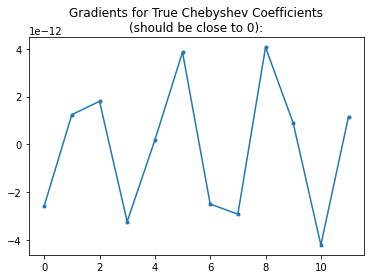

In [25]:
print('Shape cgradfn(cvec):', cgradfn(cvec).shape)

print('Gradients for True Chebyshev Coefficients (should be close to 0):', cgradfn(cvec), sep='\n')

plt.plot(cgradfn(cvec), '.-')
plt.title('Gradients for True Chebyshev Coefficients\n(should be close to 0):')
plt.show()

In [26]:
jitcgradfn = jax.jit(cgradfn)

In [27]:
print('jitcgradfn(cvec):', jitcgradfn(cvec), sep='\n')
print('jaxgradcobjfn(cvec):', jaxgradcobjfn(cvec), sep='\n')

jitcgradfn(cvec):
[-2.57426533e-12  1.24697617e-12  1.80244603e-12 -3.22312797e-12
  1.78714839e-13  3.85783991e-12 -2.48741352e-12 -2.91178557e-12
  4.06290802e-12  8.92807262e-13 -4.19652243e-12  1.16553883e-12]
jaxgradcobjfn(cvec):
[-2.57426533e-12  1.24697617e-12  1.80244603e-12 -3.22312797e-12
  1.78714839e-13  3.85783991e-12 -2.48741352e-12 -2.91178557e-12
  4.06290802e-12  8.92807262e-13 -4.19652243e-12  1.16553883e-12]


In [38]:
sumerror = 0
for i in range(100):
    randcvec = np.random.default_rng().normal(size=nc + 1) * 10
    t1 = time.time()
    mygrad = jitcgradfn(randcvec)
    t2 = time.time()
    jgrad = jaxgradcobjfn(randcvec)
    t3 = time.time()
    print( "adj time = " + str(t2-t1) )
    print( "jax time = " + str(t3-t2) )
    temperror = np.linalg.norm(mygrad - jgrad)
    sumerror += temperror
    print( "error = " + str(temperror) )

print('Mean error:', sumerror/100)

adj time = 0.007110595703125
jax time = 0.007654905319213867
error = 1.846867250488349e-12
adj time = 0.0067670345306396484
jax time = 0.006547212600708008
error = 1.2859982843948135e-12
adj time = 0.006680965423583984
jax time = 0.006475210189819336
error = 8.769271398882329e-13
adj time = 0.00664067268371582
jax time = 0.0064165592193603516
error = 5.574117166986308e-13
adj time = 0.00667119026184082
jax time = 0.0074312686920166016
error = 1.2566420193861384e-12
adj time = 0.006735086441040039
jax time = 0.00648188591003418
error = 4.507706804348308e-13
adj time = 0.006781339645385742
jax time = 0.007344722747802734
error = 1.1792681326685233e-12
adj time = 0.0066967010498046875
jax time = 0.007889032363891602
error = 6.208863112182176e-13
adj time = 0.008840322494506836
jax time = 0.010105133056640625
error = 8.536642552738038e-13
adj time = 0.009039878845214844
jax time = 0.0065860748291015625
error = 4.560028858076131e-13
adj time = 0.006680488586425781
jax time = 0.0064449310302

---

In [39]:
seed = 1234  # set to None for random initialization
# cffform = np.random.default_rng(seed).uniform(low=-0.5, high=0.5, size=cvec.shape)
cffform = np.random.default_rng(seed).uniform(low=-5.0, high=5.0, size=cvec.shape)

In [40]:
resform = spo.minimize(jitcobjfn, cffform, jac=jitcgradfn, tol=1e-15, options={'maxiter': 200, 'disp': True, 'gtol': 1e-14}).x

         Current function value: 0.000000
         Iterations: 162
         Function evaluations: 242
         Gradient evaluations: 229


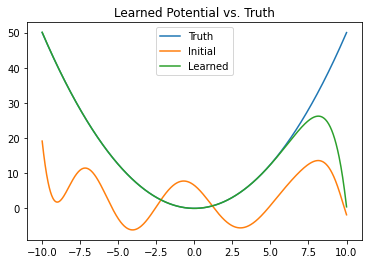

In [41]:
# print('Chebyshev Coefficients of the True Potential:', cvec, sep='\n')
# print('', 'Chebyshev Coefficients of the Learned Potential:', resform, sep='\n')

# print('Objective of the Learned Coefficients:', cobjfn(resform), sep='\n')
# print('Vec L2 Norm of Gradient of the Learned Coefficients:', nl.norm(jaxgradcobjfn(resform)), sep='\n')

# print('Continuous L2 Error of Potential using Quadrature Method:', np.sqrt(si.quad(sqrerrorfn, -L, L, args=(resform)))[0], sep='\n')

# print('', 'Gradient of the Learned Coefficients:', gradcobjfn(resform), sep='\n')

# print('', 'L2 Error of the Initialized Chebyshev Coefficients:', nl.norm(cvec - cffform), sep='\n')
# print('', 'L2 Error of the Learned Chebyshev Coefficients:', nl.norm(cvec - resform), sep='\n')
# print('', 'L-infinity Error of the Initialized Chebyshev Coefficients:', np.max(np.abs(cvec - cffform)), sep='\n')
# print('', 'L-infinity Error of the Learned Chebyshev Coefficients:', np.max(np.abs(cvec - resform)), sep='\n')

# plot learned vs true
plt.plot(xvec, vxvec, label='Truth')
plt.plot(xvec, ctoxmat @ cffform, label='Initial')
plt.plot(xvec, ctoxmat @ resform, label='Learned')
# plt.xlim((-5, 5))
# plt.ylim((0, 10))
plt.title('Learned Potential vs. Truth')
plt.legend()
plt.show()

---
<h3>Chebyshev Representation</h3>

---
**Form the Potential Matrix from the Chebyshev Representation**

In [ ]:
# check how much the Fourier representation coefficients
# constructed from the Chebyshev representation differ from
# the true Fourier coefficients
# (i.e., compare the potential in the Fourier representation
# to the potential reconstructed from the Chebyshev representation)
# print('L2 Norm Error (should be close to 0):', nl.norm(Fvtoep - CtoFmat @ cvec))  # 2.319575846403117e-13
print(sl.toeplitz(r=Fvtoep, c=np.conj(Fvtoep)).shape)
print((CtoFmat @ cvec).shape)
print('L2 Norm Error (should be close to 0):', nl.norm(sl.toeplitz(r=Fvtoep, c=np.conj(Fvtoep)) - CtoFmat @ cvec))  # 1.2698568848776662e-12
# print('a-infinity Error (should be close to 0):', np.max(np.abs(Fvtoep - CtoFmat @ cvec)))  # 1.4527419384605627e-13
print('a-infinity Error (should be close to 0):', np.max(np.abs(sl.toeplitz(r=Fvtoep, c=np.conj(Fvtoep)) - CtoFmat @ cvec)))  # 1.452737601671089e-13

---
**Eigendecomposition of a Chebyshev Represented Potential**

In [ ]:
# to test our Chebyshev representation let's compare
# the Hamiltonian matrix and its eigendecomposition
# constructed from the potential matrix reconstructed
# from the Chebyshev coefficients of the potential
# to the same features constructed directly in the
# Fourier representation

# make the potential matrix from the Chebyshev coefficents
# cvmat = sl.toeplitz(r=CtoFmat @ cvec, c=np.conj(CtoFmat @ cvec))
cvmat = CtoFmat @ cvec

# construct the Hamiltonian matrix representation of the
# Hamiltonian operator in the Fourier basis
chmat = kmat + cvmat

# check if the Hamiltonian matrix is Hermitian
print('hmat Hermitian check (should be close to zero):', nl.norm(chmat - chmat.T.conj()), sep='\n')

# eigendecomposition of the Hamiltonian matrix
cspc, cstts = nl.eigh(chmat)

# check if the eigendecomposition diagonalizes the
# Hamiltonian matrix
# if this is close to zero then
# hmat = states @ np.diag(spec) @ np.conj(states).T
print('Check if hmat is diagonalized (should be close to zero):', nl.norm(chmat @ cstts - cstts @ np.diag(cspc)), sep='\n')

# check if the eigenstates are unitary
print('Unitary stts check (should be close to zero):', nl.norm(cstts @ cstts.T.conj() - np.eye(2 * numF + 1)), sep='\n')

# results for the original way
# hmat Hermitian check (should be close to zero):
# 0.0
# Check if hmat is diagonalized (should be close to zero):
# 3.264297626570781e-13
# Unitary stts check (should be close to zero):
# 1.1878611598105484e-14

In [ ]:
print('L2 Error of the Hamiltonian matrix (should be close to 0):', nl.norm(cvmat - Fvmat), sep='\n')
print('L2 Error of spectrum (should be close to 0):', nl.norm(cspc - Fspc), sep='\n')
print('L2 Error of states (should be close to 0):', nl.norm(cstts - Fstts), sep='\n')

# results for the original way
# L2 Error of the Hamiltonian matrix (should be close to 0):
# 1.44838302671362e-12
# L2 Error of spectrum (should be close to 0):
# 5.43553446497394e-13
# L2 Error of states (should be close to 0):
# 7.48331477354788

---
**Forward Propagation of ainit using the Potential in the Cheybshev Representation**

In [ ]:
# propagate the system using the Chebyshev
# representation of the true potential and compare
# if chebyshev propagation agrees with Fourier
# propagation

# compute the propagator matrix reusing the
# spectrum and states from the eigendecomposition
# of Hamiltonian matrix computed above
# cspc, cstts
cpropa = cstts @ np.diag(np.exp(-1j * cspc * dt)) @ cstts.conj().T

# propagate the system starting from the initial "a" state
camat = np.zeros((ntsteps + 1, 2 * numF + 1), dtype=np.complex128)
camat[0] = ainit.copy()
for i in range(ntsteps):
    camat[i + 1] = cpropa @ camat[i]

# compute the wave function in space from each "a" vector
# do it all at once using matrix multiplication!
cpsimat = camat @ Fcnvrtmat

print('Done propagating.')

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=numsnapshots, sharex='all', sharey='all')

plottstep = ntsteps // numsnapshots

for j in range(numsnapshots):
    axs[1, j].plot(xvec, np.abs((camat @ Fcnvrtmat)[plottstep * j])**2)

plt.show()

In [ ]:
# check if the wave function of each time step
# is normalized to 1
# this should produce a graph with a line that is almost
# completely horizontal at 1
cpsimatnorm = si.trapezoid(np.abs(cpsimat) ** 2, xvec, axis=1)
plt.plot(np.arange(ntsteps + 1) * dt, cpsimatnorm, label='1')
plt.hlines(1 , 0, ntsteps * dt, linestyles='-.', colors='darkorange', label='_')
plt.title('Normalization of the Wave Function\nas a Function of Time\n')
plt.xlabel('Time')
plt.ylabel('Norm')
plt.legend()
plt.show()

# norm difference of wave function normalization check,
# this should be close to 1
print('Average Norm of Trajectory 1 (should be close to 1):', cpsimatnorm.sum() / (ntsteps + 1), sep='\n')